# 集成学习概述
## 目录
* 集成算法的分类
* sklearn中Voting Classifier的简单使用
    * VotingClassifier实现hard voting
    * VotingClassifier实现soft voting
* sklearn中Bagging Classifier的详细使用
    * Bagging的理论基础
    * Bagging的分类
    * Bagging Classifier的参数
    * 如何实现Bagging Classifier的四种类型
    * Bagging Classifier的属性

## 集成算法的分类：
* bagging  
    每次参考不同的数据集建立多个子模型，将子模型的预测结果少数服从多数
* boosting  
    我们生成的每一个子模型都在想办法弥补上一个模型中没有被成功预测的样本点。每一个子模型都在想办法推动上一个模型所犯的错误
    <div align=center><img src="boosting.png" style="zoom:20%">
* stacking  
    首先也是使用三个算法，用这三个算法，分别求出针对我们的数据而言，相对的预测结果。
    但是我们不直接使用这三个预测结果进行综合来得到最后的结果，我们用这三个结果作为输入，再添加一层算法。也就是说，以这三个预测结果作为输入，训练一个新的模型，以这个这个新的模型的输出，作为最终的预测结果。
    有点类似与神经网络，在原来的算法的基础上，又落了一层。
    <div align=center><img src="stacking.png" style="zoom:20%">

## sklearn中voting classifier的简单实现
bagging的方式有：
1. hard voting:少数服从多数
2. soft voting:有权重的少数服从多数

### 使用sklearn中的Voting Classifier实现hard voting
voting="hard"

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X,y = datasets.make_moons(n_samples=500,noise=0.3,random_state=666)

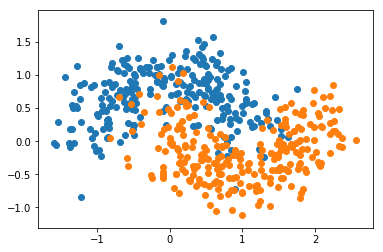

In [2]:
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [4]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

voting_clf = VotingClassifier(
    estimators=[
        ("log_clf",LogisticRegression()),
        ("SVM_clf",SVC()),
        ("dt_clf",DecisionTreeClassifier())
    ],
    voting="hard"
)

In [5]:
voting_clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('log_clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('SVM_clf'...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [6]:
voting_clf.score(X_test,y_test)

0.9133333333333333

### 使用sklearn中的Voting Classifier实现soft voting
voting = "soft"


注意：  
在进行基于权值的投票时，基于的权值是模型估计的概率，也就是算法要有predict_proba函数    
对于SVM算法，如果要计算出概率的话，会牺牲掉一定的计算时间。所以默认情况下probability=False。在进行soft voting时，要设置为True。

In [7]:
voting_clf2 = VotingClassifier(
    estimators=[
        ("log_clf",LogisticRegression()),
        ("SVM_clf",SVC(probability=True)),
        ("dt_clf",DecisionTreeClassifier())
    ],
    voting="soft"
)

In [8]:
voting_clf2.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('log_clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('SVM_clf'...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [9]:
voting_clf2.score(X_test,y_test)

0.8933333333333333

## sklearn中Bagging Classifier的详细使用
### Bagging classifier的理论基础
假设每个子模型的准确率为p，
若集成了n个准确率为p的子模型，
则采用hard voting后，  
集成模型的准确率为
$$\sum\limits_{i=ceil(\frac{n+1}{2})}^n C_{n}^i p^i (1-p)^{(n-i)}$$

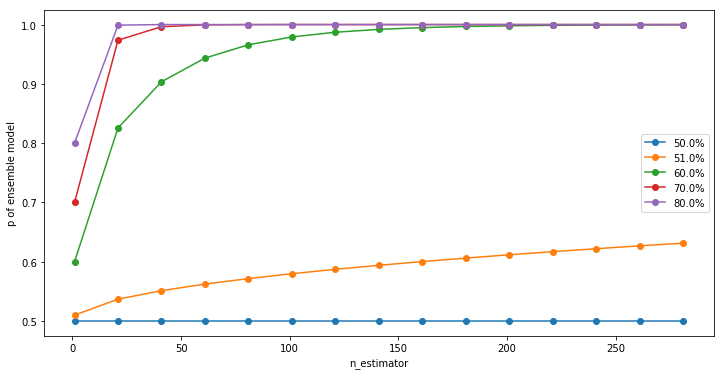

In [10]:
from scipy.special import comb
plt.figure(figsize=(12,6))
p = [0.5,0.51,0.6,0.7,0.8]
for pi in p:
    reslist = []
    for n in range(1,301,20):
        res = np.array([comb(n,i)* pi**i * (1-pi)**(n-i) for i in range(int(np.ceil((n+1)/2)),n+1)]).sum()
        reslist.append(res)
    plt.plot(range(1,301,20),reslist,'o-',label=str(pi*100)+"%")
plt.xlabel("n_estimator")
plt.ylabel("p of ensemble model")
plt.legend()
plt.show()

故每个子模型不需要太高的准确率，只要高于50%就可以。  
子模型的个数越多越好，基于内存和计算量的考虑，100左右为佳  
但如果子模型都是相同的，则集成算法并没有这样的优势。  
故子模型的生成一定要有差异性（相互独立）

### Bagging的分类
随机产生子模型（生成有差异性的子模型）的方式：
让每个子模型只看样本数据的一部分。  

对应的取样方式有：
1. Baggging(bootstrap)  
    放回取样。  
    因为取样过程重复了非常多次，故将取样的随机过程所带来的影响消除了

2. Pasting  
    不放回取样。  
    怎样划分样本，对严重影响到最终Pasting集成学习得到的结果
    
3. Random Subspaces  
    子样本的特征随机取

4. Random Patches  
    子样本的特征和样本都是随机取  
    <div align=center><img src="patch.png" style="zoom:20%">

### Bagging Classifier的参数

|-||
|:--|:--|
|base_estimator|基模型<br>默认为决策树
|n_estimators|集成的模型个数<br>默认为10
|max_samples|生成每个基模型时，从整体样本中抽取多少个子样本<br>默认为1<br>int,则抽取max_samples个样本<br>float,抽取max_samples*X.shape[0]个样本
|max_features|生成每个基模型时，从整体特征中抽取多少个特征<br>默认为1<br>int,抽取max_features样本<br>float,抽取max_features*X.shape[1]个特征
|bootstrap|是否有放回<br>默认为True（有放回）
|bootstrap_features|特征提取是否有放回<br>默认为False
|oob_score|是否使用袋外数据来预测泛化误差<br>默认为False
|verbose|在训练和预测时，控制verboseity的数量<br>默认为0

一般Bagging时，选用决策树为子模型的原因是，决策树这种非参数学习的算法更能产生差异相对比较大的子模型。  
他里面有很多的参数，很多的剪枝方式，都能帮助我们使得集成的每一个子模型更加有差异，或者说是更加的随机，这种样子是集成学习喜欢的样子，他喜欢我们集成的每一个子模型要有区别。  
不然的话，我们集成了1000个子模型，每个子模型都一样，那么集成的意义就没有了。  
所以通常在集成学习中，如果我们要集成成百上千个子模型，首选就是决策树。

采用决策树作为子模型进行bagging

In [11]:
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,#集成几棵树
    max_samples=100,#每个子模型最多看几个样本数据
    bootstrap=True#放回取样
                               )

In [12]:
bagging_clf.fit(X_train,y_train)
bagging_clf.score(X_test,y_test)

0.9

In [13]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.8933333333333333

采用SVM作为子模型进行bagging

In [14]:
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(
    SVC(gamma='auto'),
    n_estimators=500,
    max_samples=100,
    bootstrap=True
)

In [15]:
bagging_clf.fit(X_train,y_train)
bagging_clf.score(X_test,y_test)

0.92

In [16]:
clf = SVC(gamma="auto")
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.92

会发现，采用决策树，集成算法得到的准确率会有很大提升，但是如果采用SVM，则集成算法的准确率提升不大

放回取样会存在另一个问题，虽然是随机取样，但就是有些样本可能无法被取到。所以我们在进行测试数据集时，可以使用这部分没有被取到的样本进行测试。

没有被取到的样本大约有37%
对于有n_sample个样本的样本集，每次有放回取n个样本，一个样本不被取到的概率为
$$p = 1-\frac{1}{n_{sample}}$$
取n次
则取n次都不会为取到的概率为
$$p^n = (1-\frac{1}{n_{sample}})^n$$
当n_samle与n都接近无穷时，
$$ \lim \limits_{n->\inf}(1-\frac{1}{n})^n = e^{-1} = 0.37$$

故可以使用oob来进行测试

In [17]:
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True,
    oob_score=True #在进行放回取样的过程中，记录下哪些样本被取了，哪些样本没被取
)
bagging_clf.fit(X,y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=None, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [18]:
bagging_clf.oob_score_ #查看在为取样的样本中的测试表现

0.892

### 如何实现Bagging Classifier的四种类型
|-||
|:--|:--|
|Bagging|booststrap=True|
|Pasting|booststrap=False|
|Random Subspaces|max_features=0.8#只要不是1.0就可以|
|Random Patches|max_samples=0.8 #只要不是1.0就可以<br>max_features=0.8 #只要不是1.0就可以

Random Subspaces 针对特征进行随机采样  
Random Patches 针对特征和样本进行随机采样

In [19]:
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500,#集成几个决策树这样的模型
                               max_samples=500,#每个子模型看几个样本数据
                               bootstrap=True,
                               oob_score=True,#告诉Bagging这个类，具体放回取样的过程中，我们还需要记录下，到底取了哪些样？相应的才能知道哪些样本没有被取到。
                               n_jobs=-1,
                               max_features=0.8,#每次对特征进行随机取样
                               bootstrap_features=False)#放回取样
random_subspaces_clf.fit(X,y)
random_subspaces_clf.oob_score_

0.824

In [20]:
random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500,#集成几个决策树这样的模型
                               max_samples=100,#每个子模型看几个样本数据
                               bootstrap=True,
                               oob_score=True,#告诉Bagging这个类，具体放回取样的过程中，我们还需要记录下，到底取了哪些样？相应的才能知道哪些样本没有被取到。
                               n_jobs=-1,
                               max_features=0.8,#每次对我们的特征进行随机取样
                               bootstrap_features=False)#放回取样
random_patches_clf.fit(X,y)
random_patches_clf.oob_score_

0.882

一般来说random_patches的准确率更高。

主要是因为我们在这个数据上,对样本的数量进行放回取样，增大了每个子模型的差异性。

故最终这个模型产生的准确率是更高的。

### Bagging Classifier的属性
|-||
|:--|:--|
|base_estimator_||
|estimators_|查看基模型|
|estimators_features|子模型所抽取的特征
|oob_score_|用袋外数据预测出来的分数